In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('D:/Advanced_Computing/Active_Experiments/LSTM/stock_market/all_stocks_5yr.csv')

In [2]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
df[4000:4005]
abbv = df[df['Name']=='ABBV']

In [4]:
len(set(df['Name']))

505

In [5]:
aal = df[df['Name']=='AAL']
aal = aal.sort_values("date")

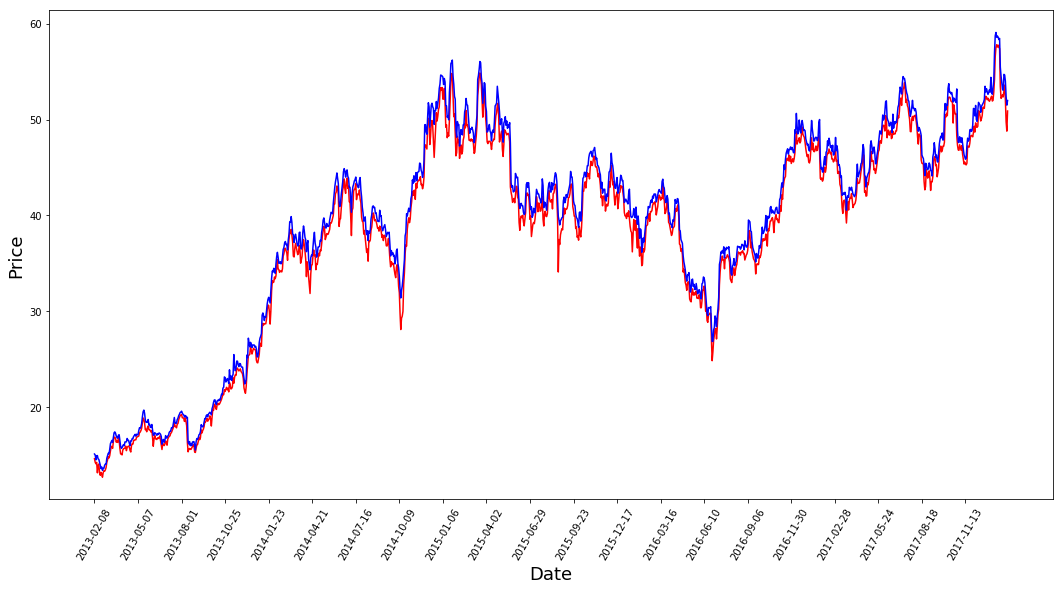

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(aal.shape[0]),(aal['low']), color='r')
plt.plot(range(aal.shape[0]),(aal['high']), color = 'b')
plt.xticks(range(0,aal.shape[0],60),aal['date'].loc[::60],rotation=60)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

In [7]:
high_prices = aal.loc[:,'high'].values
low_prices = aal.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [8]:
mid_prices.shape

(1259,)

In [9]:
mid_prices

array([14.875, 14.635, 14.305, ..., 51.07 , 50.145, 51.435])

In [10]:
train_data = mid_prices[:1000]
test_data = mid_prices[1000:1251]


In [11]:
train_data = train_data.reshape(-1,1)                                                       #scaler.fit_transform
test_data = test_data.reshape(-1,1)                                                        #scaler.fit_transform

In [12]:
print('%d training and %d total testing instances'%(len(train_data), len(test_data)))

1000 training and 251 total testing instances


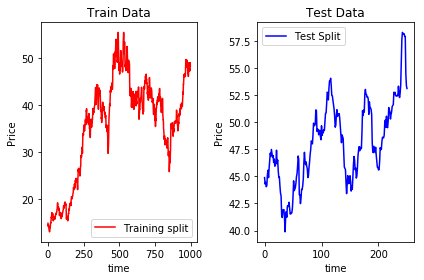

In [13]:
#Subplot with training data
plt.subplot(1,2,1)
plt.plot(range(train_data.shape[0]),train_data,color='r',label='Training split')
plt.title('Train Data')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend()

#Subplot with test data
plt.subplot(1,2,2)
plt.plot(range(test_data.shape[0]),test_data,color='b',label='Test Split')
plt.title('Test Data')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend()

#adjust layout and plot all
plt.tight_layout()
plt.show()

In [14]:
#Window size to normalize data in chunks 
normalization_window = 250

#Feature range for normalization
scaler = MinMaxScaler(feature_range=(0, 1))


In [15]:
# Loop over the training data in windows of 250 instances at a time
for i in range(0,1000,normalization_window):
    
    # Fit the scaler object on the data in the current window
    scaler.fit(train_data[i:i+normalization_window,:])
    
    # Transform the data in the current window into values between the chosen feature range (0 and 1)
    train_data[i:i+normalization_window,:] = scaler.transform(train_data[i:i+normalization_window,:])
    

In [16]:
# normalize the the test data
test_data=scaler.fit_transform(test_data)

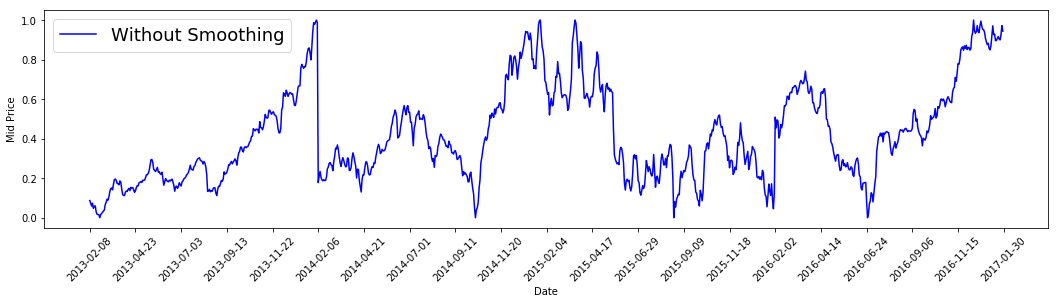

In [17]:
# Plot normalized data

plt.figure(figsize = (18,4))
plt.plot(range(train_data.shape[0]),train_data,color='b',label='Without Smoothing')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [18]:
Smoothing = 0.0     #Initialize smoothing value as zero

gamma = 0.1         #Define decay


for i in range(1000):
      
    Smoothing = gamma*train_data[i] + (1-gamma)*Smoothing    # Update smoothing value
    
    train_data[i] = Smoothing                                # Replace datapoint with smoothened value

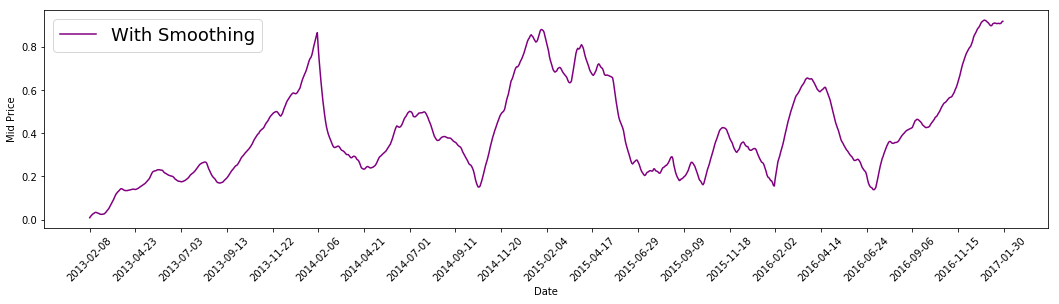

In [19]:
# Plot smooth-ened curve

plt.figure(figsize = (18,4))
plt.plot(range(train_data.shape[0]),train_data,color='purple',label='With Smoothing')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error


window_size = 26            # Define window size
N = train_data.size         # and length of observations

std_avg_predictions = []    # Empty list to catch std
mse_errors = []             # and mse


for i in range(window_size,N):
    
    std_avg_predictions.append(np.mean(train_data[i-window_size:i]))  # Append the standard mean per window 
    
    mse_errors.append((std_avg_predictions[-1]-train_data[i])**2)     # Compute mean squared error per batch

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00444


In [21]:
print(' No. of obs :' , len(train_data))
print(' Std av. predictions :', len(std_avg_predictions))

 No. of obs : 1000
 Std av. predictions : 974


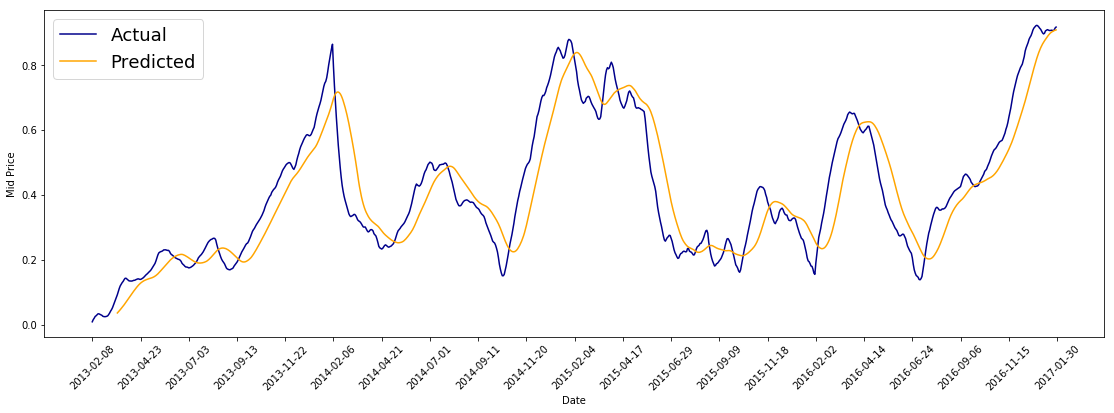

In [22]:
# Plot standard moving average predictions

plt.figure(figsize = (19,6))
plt.plot(range(train_data.shape[0]),train_data,color='darkblue',label='Actual')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Predicted')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [23]:
ob = 200
print('Predicted:', train_data[ob],  'actual:',std_avg_predictions[ob])

Predicted: [0.48909624] actual: 0.5278803889434908


In [24]:
# Computing Exponential Moving Average (EMA)

ema_avg_predictions = []
mse_errors = []

EMA = 0.0
ema_avg_predictions.append(EMA)

gamma = 0.5
window_size = 100
N = len(train_data)

for i in range(1,N):
    EMA = EMA*gamma + (1.0-gamma)*train_data[i-1]
    ema_avg_predictions.append(EMA)
    mse_errors.append((ema_avg_predictions[-1]-train_data[i])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00018


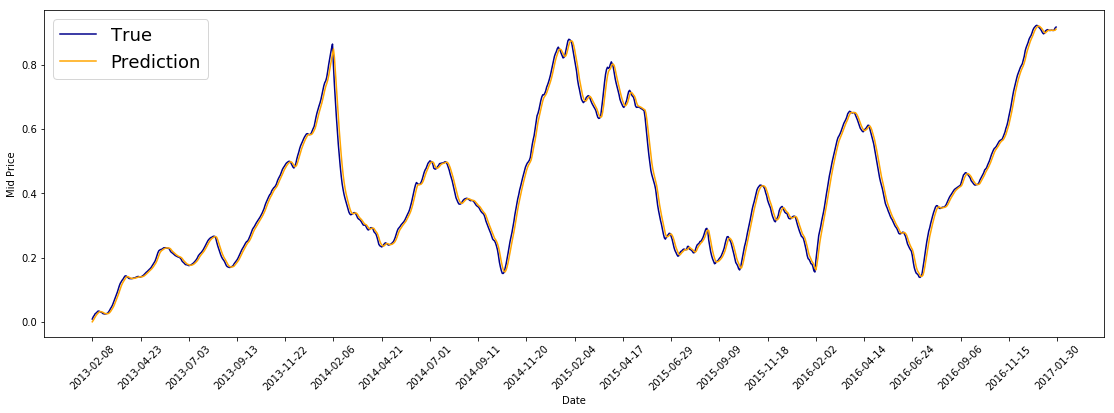

In [26]:
# Plotting EMA predictions 

plt.figure(figsize = (19,6))
plt.plot(range(train_data.shape[0]),train_data,color='darkblue',label='True')
plt.plot(range(0,N),ema_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


In [28]:
# Testing on a single observation

num_ob = 25
print('Predicted:', train_data[num_ob],  'Actual:',ema_avg_predictions[num_ob])

Predicted: [0.08368467] Actual: [0.06933803]


In [29]:
# Function to create dataset

def create_dataset(dataset, look_back=7, foresight=3):   
    
    X, Y = [], []
    
    for i in range(len(dataset)-look_back-foresight):
        
        obs = dataset[i:(i+look_back), 0]                   # Sequence of 7 stock prices as features forming an observation
        
        X.append(obs)                                       # Append sequence 
        
        Y.append(dataset[i + (look_back+foresight), 0])     # Append stock price value occuring 4 time-steps into future
        
    return np.array(X), np.array(Y)

In [30]:
# Define lookback window length and lag between label
look_back, foresight = 7, 3

x_train, y_train = create_dataset(train_data, look_back, foresight)
x_test, y_test = create_dataset(test_data, look_back, foresight)

In [31]:
# Reshape data

x_train = np.reshape(x_train, (x_train.shape[0], 1,  x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1,  x_test.shape[1]))

In [32]:
# Check shape

x_train.shape

(990, 1, 7)

In [33]:
# Check and individual observation and its label 

x_train[0], y_train[0]

(array([[0.00867591, 0.015337  , 0.01975454, 0.02511656, 0.02738502,
         0.03043046, 0.03341036]]), 0.028595272260547346)

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten

from keras.callbacks import ModelCheckpoint, EarlyStopping

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [971]:
# Simple feed forward baseline

def feed_forward():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [887]:
# 1D Convolutional baseline (to experiment with)

def conv1D_net():
    model = Sequential()
    model.add(Conv1D(32, 2, activation='relu', input_shape=(1, 8)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [888]:
# Simple GRU with dropout

def simple_gru():
    model = Sequential()
    model.add(GRU(32,  input_shape=(1, 7), dropout=0.1, recurrent_dropout=0.1))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam', metrics = ['mean_absolute_error'])
    return model
    

In [889]:
# Advanced model combining 1D convs for downsampling then GRUs for time-dependent information encoding (to experimnent with)

def conv1D_gru_net():
    model = Sequential()
    model.add(Conv1D(32, 1, activation='relu', input_shape=(1, 7)))
    model.add(MaxPooling1D(1))
    model.add(Conv1D(32, 1, activation='relu'))
    model.add(GRU(32, dropout=0.1, recurrent_dropout=0.2))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam')
    return model

In [890]:
# Simple LSTM

def simple_lstm():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, 7)))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam')
    return model
    

In [897]:
# Stacked LSTM

def lstm_stacked():
    model = Sequential()
    model.add(LSTM(16, input_shape=(1, 7), dropout=0.1, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(16, dropout=0.1, recurrent_dropout=0.2))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam')
    return model

In [892]:
# Stateful LSTM
def lstm_stateful():
    model = Sequential()
    model.add(LSTM(32,
                   batch_input_shape=(1, 1, 7),
                   stateful=True,
                   dropout=0.1,
                   recurrent_dropout=0.1))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam')
    return model

In [1019]:
# Helper function to plot losses

def plot_losses(network):
    plt.plot(network.history['loss'], label='loss')
    plt.plot(network.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    plt.clf()

In [1034]:
# Helper function to plot preds

def plot_predictions(model, y_test=y_test):
    
    preds = model.predict(x_test)
    plt.figure(figsize = (12,6))
    plt.plot(scaler.inverse_transform(preds.reshape(-1,1)), label='generated', color='orange')
    plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Actual')
    plt.legend()
    plt.show()

In [1036]:
def train_network(list, x_train, y_train, epochs=5):
    
    for net in list:               
        
        network_name = str(net).split(' ')[1]
        filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
        print('Training:', network_name)
        
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        callbacks_list = [checkpoint] 
        model = net()                  
        
        network = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=epochs,
                            batch_size=64,
                            callbacks=callbacks_list)
        model.summary()
        plot_predictions(model, y_test)
        
    return network, model

Training: feed_forward
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 10s 10ms/step - loss: 0.2645 - val_loss: 0.0909
Epoch 2/50
990/990 [==============================] - 0s 84us/step - loss: 0.0810 - val_loss: 0.0961
Epoch 3/50
990/990 [==============================] - 0s 83us/step - loss: 0.0594 - val_loss: 0.0913
Epoch 4/50
990/990 [==============================] - 0s 101us/step - loss: 0.0510 - val_loss: 0.0917
Epoch 5/50
990/990 [==============================] - 0s 83us/step - loss: 0.0459 - val_loss: 0.0910
Epoch 6/50
990/990 [==============================] - 0s 87us/step - loss: 0.0445 - val_loss: 0.0901
Epoch 7/50
990/990 [==============================] - 0s 85us/step - loss: 0.0439 - val_loss: 0.0889
Epoch 8/50
990/990 [==============================] - 0s 92us/step - loss: 0.0432 - val_loss: 0.0879
Epoch 9/50
990/990 [==============================] - 0s 86us/step - loss: 0.0423 - val_loss: 0.0865
Epoch 10/50
990/990 

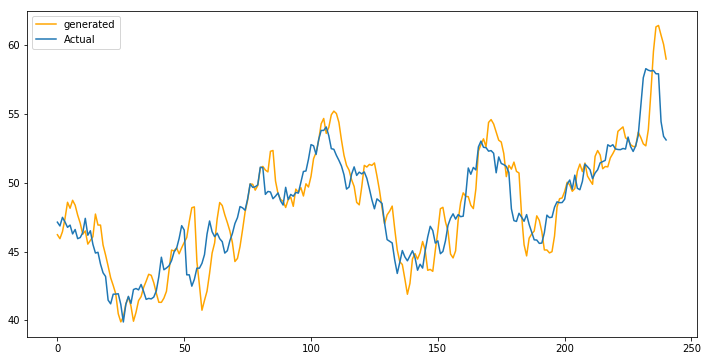

Training: simple_gru
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 11s 11ms/step - loss: 0.2869 - mean_absolute_error: 0.2869 - val_loss: 0.1832 - val_mean_absolute_error: 0.1832
Epoch 2/50
990/990 [==============================] - 0s 103us/step - loss: 0.0882 - mean_absolute_error: 0.0882 - val_loss: 0.0934 - val_mean_absolute_error: 0.0934
Epoch 3/50
990/990 [==============================] - 0s 99us/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 4/50
990/990 [==============================] - 0s 95us/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0929 - val_mean_absolute_error: 0.0929
Epoch 5/50
990/990 [==============================] - 0s 108us/step - loss: 0.0564 - mean_absolute_error: 0.0564 - val_loss: 0.0904 - val_mean_absolute_error: 0.0904
Epoch 6/50
990/990 [==============================] - 0s 102us/step - loss: 0.0571 - mean_absolute_error:

Epoch 50/50
990/990 [==============================] - 0s 107us/step - loss: 0.0564 - mean_absolute_error: 0.0564 - val_loss: 0.0903 - val_mean_absolute_error: 0.0903
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 32)                3840      
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 33        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


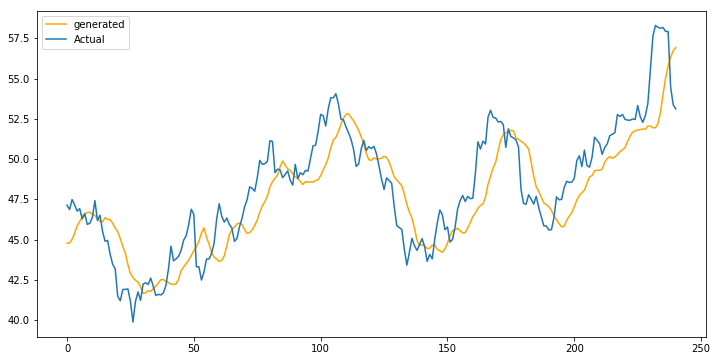

Training: simple_lstm
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 10s 10ms/step - loss: 0.4206 - val_loss: 0.3751
Epoch 2/50
990/990 [==============================] - 0s 104us/step - loss: 0.2748 - val_loss: 0.2261
Epoch 3/50
990/990 [==============================] - 0s 114us/step - loss: 0.1328 - val_loss: 0.1102
Epoch 4/50
990/990 [==============================] - 0s 109us/step - loss: 0.0742 - val_loss: 0.0954
Epoch 5/50
990/990 [==============================] - 0s 112us/step - loss: 0.0683 - val_loss: 0.0936
Epoch 6/50
990/990 [==============================] - 0s 108us/step - loss: 0.0606 - val_loss: 0.0924
Epoch 7/50
990/990 [==============================] - 0s 109us/step - loss: 0.0541 - val_loss: 0.0913
Epoch 8/50
990/990 [==============================] - 0s 111us/step - loss: 0.0497 - val_loss: 0.0911
Epoch 9/50
990/990 [==============================] - 0s 112us/step - loss: 0.0466 - val_loss: 0.0912
Epoch 10/50
99

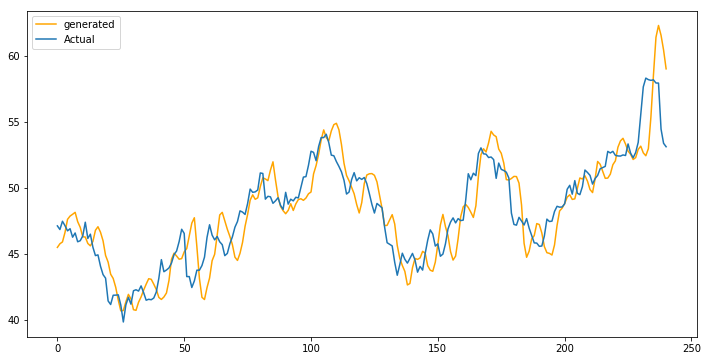

Training: lstm_stacked
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 12s 12ms/step - loss: 0.3960 - val_loss: 0.3984
Epoch 2/50
990/990 [==============================] - 0s 143us/step - loss: 0.3345 - val_loss: 0.3273
Epoch 3/50
990/990 [==============================] - 0s 157us/step - loss: 0.2534 - val_loss: 0.2318
Epoch 4/50
990/990 [==============================] - 0s 154us/step - loss: 0.1497 - val_loss: 0.1284
Epoch 5/50
990/990 [==============================] - 0s 154us/step - loss: 0.0970 - val_loss: 0.0984
Epoch 6/50
990/990 [==============================] - 0s 143us/step - loss: 0.0907 - val_loss: 0.0977
Epoch 7/50
990/990 [==============================] - 0s 143us/step - loss: 0.0800 - val_loss: 0.0951
Epoch 8/50
990/990 [==============================] - 0s 160us/step - loss: 0.0711 - val_loss: 0.0918
Epoch 9/50
990/990 [==============================] - 0s 146us/step - loss: 0.0666 - val_loss: 0.0937
Epoch 10/50
9

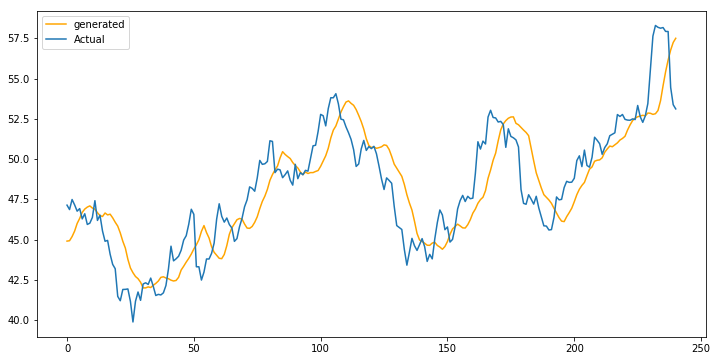

(<keras.callbacks.History at 0x13a13ecf4e0>,
 <keras.engine.sequential.Sequential at 0x13a032b42e8>)

In [1037]:
all_networks = [feed_forward, simple_gru, simple_lstm, lstm_stacked]
train_network(all_networks, x_train, y_train, epochs=50)

In [981]:
preds = model.predict(x_test) #batch_size=1

In [840]:
model.predict(x_test[1:2])

array([[0.26050293]], dtype=float32)